In [ ]:
from typing import Dict, Tuple
from tqdm import tqdm
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
import requests
from io import BytesIO
from PIL import Image
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(0)

#Do not change, it will break the AutoGrader
import_block = In[-1]

# Helper modules
Implementation of common CNN blocks used in UNet, normalization and denormalization functions, functions for plotting, and dataset.

In [ ]:
class ResidualConvBlock(nn.Module):
    def __init__(
        self, in_channels: int, out_channels: int, is_res: bool = False
    ) -> None:
        super().__init__()

        # Check if input and output channels are the same for the residual connection
        self.same_channels = in_channels == out_channels

        # Flag for whether or not to use residual connection
        self.is_res = is_res

        # First convolutional layer
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

        # Second convolutional layer
        self.conv2 = nn.Sequential(
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),   # 3x3 kernel with stride 1 and padding 1
            nn.BatchNorm2d(out_channels),   # Batch normalization
            nn.GELU(),   # GELU activation function
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:

        # If using residual connection
        if self.is_res:
            # Apply first convolutional layer
            x1 = self.conv1(x)

            # Apply second convolutional layer
            x2 = self.conv2(x1)

            # If input and output channels are the same, add residual connection directly
            if self.same_channels:
                out = x + x2
            else:
                # If not, apply a 1x1 convolutional layer to match dimensions before adding residual connection
                shortcut = nn.Conv2d(x.shape[1], x2.shape[1], kernel_size=1, stride=1, padding=0).to(x.device)
                out = shortcut(x) + x2
            #print(f"resconv forward: x {x.shape}, x1 {x1.shape}, x2 {x2.shape}, out {out.shape}")

            # Normalize output tensor
            return out / 1.414

        # If not using residual connection, return output of second convolutional layer
        else:
            x1 = self.conv1(x)
            x2 = self.conv2(x1)
            return x2

    # Method to get the number of output channels for this block
    def get_out_channels(self):
        return self.conv2[0].out_channels

    # Method to set the number of output channels for this block
    def set_out_channels(self, out_channels):
        self.conv1[0].out_channels = out_channels
        self.conv2[0].in_channels = out_channels
        self.conv2[0].out_channels = out_channels



class UnetUp(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetUp, self).__init__()

        # Create a list of layers for the upsampling block
        # The block consists of a ConvTranspose2d layer for upsampling, followed by two ResidualConvBlock layers
        layers = [
            nn.ConvTranspose2d(in_channels, out_channels, 2, 2),
            ResidualConvBlock(out_channels, out_channels),
            ResidualConvBlock(out_channels, out_channels),
        ]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        # Concatenate the input tensor x with the skip connection tensor along the channel dimension
        x = torch.cat((x, skip), 1)

        # Pass the concatenated tensor through the sequential model and return the output
        x = self.model(x)
        return x


class UnetDown(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UnetDown, self).__init__()

        # Create a list of layers for the downsampling block
        # Each block consists of two ResidualConvBlock layers, followed by a MaxPool2d layer for downsampling
        layers = [ResidualConvBlock(in_channels, out_channels), ResidualConvBlock(out_channels, out_channels), nn.MaxPool2d(2)]

        # Use the layers to create a sequential model
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # Pass the input through the sequential model and return the output
        return self.model(x)

class EmbedFC(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedFC, self).__init__()
        '''
        This class defines a generic one layer feed-forward neural network for embedding input data of
        dimensionality input_dim to an embedding space of dimensionality emb_dim.
        '''
        self.input_dim = input_dim

        # define the layers for the network
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
        ]

        # create a PyTorch sequential model consisting of the defined layers
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        # flatten the input tensor
        x = x.view(-1, self.input_dim)
        # apply the model layers to the flattened tensor
        return self.model(x)

def unorm(x):
    # unity norm. results in range of [0,1]
    # assume x (h,w,3)
    xmax = x.max((0,1))
    xmin = x.min((0,1))
    return(x - xmin)/(xmax - xmin)

def norm_all(store, n_t, n_s):
    # runs unity norm on all timesteps of all samples
    nstore = np.zeros_like(store)
    for t in range(n_t):
        for s in range(n_s):
            nstore[t,s] = unorm(store[t,s])
    return nstore

def norm_torch(x_all):
    # runs unity norm on all timesteps of all samples
    # input is (n_samples, 3,h,w), the torch image format
    x = x_all.cpu().numpy()
    xmax = x.max((2,3))
    xmin = x.min((2,3))
    xmax = np.expand_dims(xmax,(2,3))
    xmin = np.expand_dims(xmin,(2,3))
    nstore = (x - xmin)/(xmax - xmin)
    return torch.from_numpy(nstore)

def gen_tst_context(n_cfeat):
    """
    Generate test context vectors
    """
    vec = torch.tensor([
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],      # human, non-human, food, spell, side-facing
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],      # human, non-human, food, spell, side-facing
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],      # human, non-human, food, spell, side-facing
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],      # human, non-human, food, spell, side-facing
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0],      # human, non-human, food, spell, side-facing
    [1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,1,0], [0,0,0,0,1],  [0,0,0,0,0]]      # human, non-human, food, spell, side-facing
    )
    return len(vec), vec

def plot_grid(x,n_sample,n_rows,save_dir,w):
    # x:(n_sample, 3, h, w)
    ncols = n_sample//n_rows
    grid = make_grid(norm_torch(x), nrow=ncols)  # curiously, nrow is number of columns.. or number of items in the row.
    save_image(grid, save_dir + f"run_image_w{w}.png")
    print('saved image at ' + save_dir + f"run_image_w{w}.png")
    return grid

def plot_sample(x_gen_store,n_sample,nrows,save_dir, fn,  w, save=False):
    ncols = n_sample//nrows
    sx_gen_store = np.moveaxis(x_gen_store,2,4)                               # change to Numpy image format (h,w,channels) vs (channels,h,w)
    nsx_gen_store = norm_all(sx_gen_store, sx_gen_store.shape[0], n_sample)   # unity norm to put in range [0,1] for np.imshow

    # create gif of images evolving over time, based on x_gen_store
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True,figsize=(ncols,nrows))
    def animate_diff(i, store):
        print(f'gif animating frame {i} of {store.shape[0]}', end='\r')
        plots = []
        for row in range(nrows):
            for col in range(ncols):
                axs[row, col].clear()
                axs[row, col].set_xticks([])
                axs[row, col].set_yticks([])
                plots.append(axs[row, col].imshow(store[i,(row*ncols)+col]))
        return plots
    ani = FuncAnimation(fig, animate_diff, fargs=[nsx_gen_store],  interval=200, blit=False, repeat=True, frames=nsx_gen_store.shape[0])
    plt.close()
    if save:
        ani.save(save_dir + f"{fn}_w{w}.gif", dpi=100, writer=PillowWriter(fps=5))
        print('saved gif at ' + save_dir + f"{fn}_w{w}.gif")
    return ani


class CustomDataset(Dataset):
    def __init__(self, surl, lurl, transform, null_context=False):
        sresponse = requests.get(surl)
        sresponse.raise_for_status()
        self.sprites = np.load(BytesIO(sresponse.content))

        lresponse = requests.get(lurl)
        lresponse.raise_for_status()
        self.slabels = np.load(BytesIO(lresponse.content))

        print(f"sprite shape: {self.sprites.shape}")
        print(f"labels shape: {self.slabels.shape}")
        self.transform = transform
        self.null_context = null_context
        self.sprites_shape = self.sprites.shape
        self.slabel_shape = self.slabels.shape

    # Return the number of images in the dataset
    def __len__(self):
        return len(self.sprites)

    # Get the image and label at a given index
    def __getitem__(self, idx):
        # Return the image and label as a tuple
        if self.transform:
            image = self.transform(self.sprites[idx])
            if self.null_context:
                label = torch.tensor(0).to(torch.int64)
            else:
                label = torch.tensor(self.slabels[idx]).to(torch.int64)
        return (image, label)

    def getshapes(self):
        # return shapes of data and labels
        return self.sprites_shape, self.slabel_shape

#Do not change, it will break the AutoGrader
helper_block = In[-1]

# Model architecture: UNet

Your first task is to implement the forward function of UNet. The network takes a noisy image, timestep, and additional context information (image class) and predicts the noise added to the image. Specifically:
- init_conv embeds the image into the feature space.
- Each down block downsamples the spatial resolution of the previous layer by 2 but doubles the feature dimension.
- to_vec reduces the spatial resolution to 1x1 by average pooling.
- The first up block up0 upsamples the spatial resolution of the hidden vector by 4.
- Each subsequent up block takes the output of the previous up block, the output of the down block at the same level (up1-down2, up2-down1), the time embedding, and the context embedding, and outputs a tensor with reduced feature dimension but doubled spatial resolution.
-  The output layer takes the output of up2 and outputs a tensor of the same shape as the input image.

The figures below depect the network architecture and how to incorporate timestep and context embeddings in each up block. Pseudo code for getting up1 is:

```
up1 = self.up1(cemb1*up0 + temb1, down2)
```



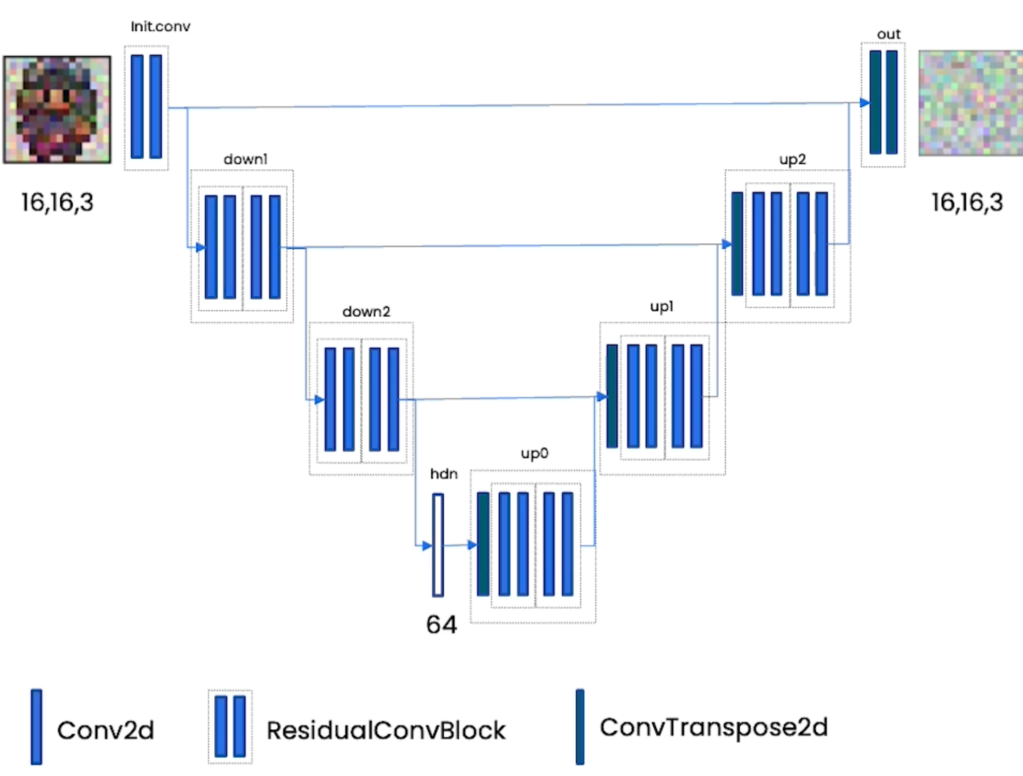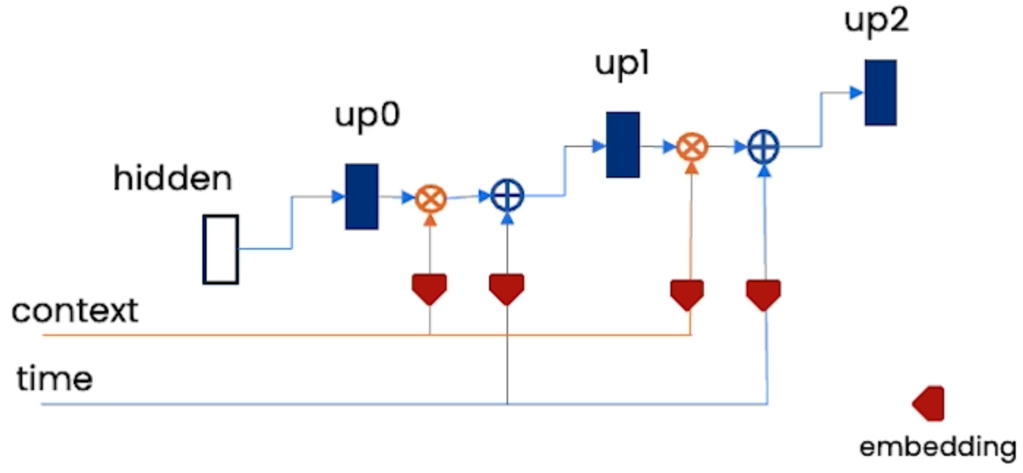

In [ ]:
class ContextUnet(nn.Module):
    def __init__(self, in_channels=3, n_feat=64, n_cfeat=5, height=16):
        super(ContextUnet, self).__init__()
        """
        in_channels : number of input channels
        n_feat : number of intermediate feature maps
        n_cfeat : number of classes
        height: height of the image
        """
        self.in_channels = in_channels
        self.n_feat = n_feat
        self.n_cfeat = n_cfeat
        self.h = height  #assume h == w. must be divisible by 4

        # the initial convolutional layer
        self.init_conv = ResidualConvBlock(in_channels, n_feat, is_res=True) # [B, 3, 16, 16] -> [B, 64, 16, 16]

        # the down-sampling path of the U-Net with two levels
        self.down1 = UnetDown(n_feat, n_feat)        # [B, 64, 16, 16] -> [B, 64, 8, 8]
        self.down2 = UnetDown(n_feat, 2 * n_feat)    # [B, 64, 8, 8] -> [B, 128, 4, 4]

        self.to_vec = nn.Sequential(nn.AvgPool2d((4)), nn.GELU()) # [B, 128, 4, 4] -> [B, 128, 1, 1]

        # embedding layers for the timestep and context labels
        self.timeembed1 = EmbedFC(1, 2*n_feat) # [B, 1] -> [B, 128]
        self.timeembed2 = EmbedFC(1, 1*n_feat) # [B, 1] -> [B, 64]
        self.contextembed1 = EmbedFC(n_cfeat, 2*n_feat) # [B, 5] -> [B, 128]
        self.contextembed2 = EmbedFC(n_cfeat, 1*n_feat) # [B, 5] -> [B, 64]

        # the up-sampling path of the U-Net with three levels
        self.up0 = nn.Sequential(
            nn.ConvTranspose2d(2 * n_feat, 2 * n_feat, self.h//4, self.h//4), # up-sample
            nn.GroupNorm(8, 2 * n_feat), # normalize
            nn.ReLU(),
        ) # [B, 128, 1, 1] -> [B, 128, 4, 4]
        self.up1 = UnetUp(4 * n_feat, n_feat) # [B, 256, 4, 4] -> [B, 64, 8, 8]
        self.up2 = UnetUp(2 * n_feat, n_feat) # [B, 128, 8, 8] -> [B, 64, 16, 16]

        # the final convolutional layers to map to the same number of channels as the input image
        self.out = nn.Sequential(
            nn.Conv2d(2 * n_feat, n_feat, 3, 1, 1),
            nn.GroupNorm(8, n_feat), # normalize
            nn.ReLU(),
            nn.Conv2d(n_feat, self.in_channels, 3, 1, 1),
        ) # [B, 128, 16, 16] -> [B, 3, 16, 16]

    def forward(self, x, t, c=None):
        """
        x : (batch, n_feat, h, w) : input image
        t : (batch, 1)            : time step
        c : (batch, n_cfeat)      : context label
        """
        init_conv = None

        # downsampling path
        down1 = None
        down2 = None

        hiddenvec = None

        if c is None:
            c = None

        # embed context and timestep
        cemb1 = None
        temb1 = None
        cemb2 = None
        temb2 = None

        # upsampling path
        up0 = None
        up1 = None
        up2 = None
        out = None
        ###########################################################
        # TODO:                                                   #
        # Implement the forward pass of the ContextUnet.          #
        # If c is None, replace it with an all-zeros tensor       #
        # the output tensor should have the same shape as input x #
        ###########################################################
        ###########################################################
        #                    END OF YOUR CODE                     #
        ###########################################################
        return out

#Do not change, it will break the AutoGrader
unet_def = In[-1]

### UNet forward test

In [ ]:
def test_unet_forward():
    torch.set_default_device("cpu")
    set_seed(0)
    model = ContextUnet(3, 64, 5, 16)
    x = torch.randn(1, 3, 16, 16)
    t = torch.randn(1)
    out = model(x, t)
    assert torch.allclose(out[0, :, 0, 0], torch.tensor([-0.3341, -0.1650,  0.0482], dtype=out.dtype), atol=1e-04)
    print ('Success')

test_unet_forward()

# Setting things up
Define hyperparameters and setup the data loader.

In [ ]:
# hyperparameters

# diffusion hyperparameters
timesteps = 500
beta1 = 1e-4
beta2 = 0.02

# network hyperparameters
device = 'cpu'
n_feat = 64 # 64 hidden dimension feature
n_cfeat = 5 # context vector is of size 5
height = 16 # 16x16 image
save_dir = './weights/'

# training hyperparameters
batch_size = 100
n_epoch = 10
lrate=1e-3

In [ ]:
# load dataset
dataset = CustomDataset(
    "https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/main/sprites_1788_16x16.npy",
    "https://huggingface.co/datasets/ashis-palai/sprites_image_dataset/resolve/main/sprite_labels_nc_1788_16x16.npy",
    transform=transforms.Compose([
        transforms.ToTensor(),                # from [0,255] to range [0.0,1.0]
        transforms.Normalize((0.5,), (0.5,))  # range [-1,1]

    ]),
    null_context=False
)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=1)

# DDPM noise schedule

In [ ]:
def construct_ddpm_noise(timesteps, beta1, beta2, device):
    beta_t = None
    alpha_t = None
    alpha_bar_t = None
    #######################################################################
    # TODO:                                                               #
    # Implement the noise schedule for the forward diffusion process.     #
    # Should return 3 tensors: beta_t, alpha_t, and alpha_bar_t           #
    # Output shape: [timesteps + 1]                                       #
    # Read the DDPM paper (sections 2 and 4) for how to                   #
    # construct beta_t, and compute alpha_t and alpha_bar_t               #
    # Reference: https://arxiv.org/pdf/2006.11239.pdf                     #
    #######################################################################
    #######################################################################
    #                           END OF YOUR CODE                          #
    #######################################################################
    alpha_bar_t[0] = 1
    return beta_t, alpha_t, alpha_bar_t

#Do not change, it will break the AutoGrader
noise_schedule_def = In[-1]

### Noise schedule test

In [ ]:
def test_noise_schedule():
    torch.set_default_device("cpu")
    set_seed(0)
    beta_t, alpha_t, alpha_bar_t = construct_ddpm_noise(5, 1e-3, 1e-1, 'cpu')

    assert torch.allclose(
        beta_t,
        torch.tensor([0.0010, 0.0208, 0.0406, 0.0604, 0.0802, 0.1000], dtype=beta_t.dtype),
      )
    print ('Success 1')

    assert torch.allclose(
        alpha_t,
        torch.tensor([0.9990, 0.9792, 0.9594, 0.9396, 0.9198, 0.9000], dtype=beta_t.dtype),
      )
    print ('Success 2')

    assert torch.allclose(
        alpha_bar_t,
        torch.tensor([1.0000, 0.9782, 0.9385, 0.8818, 0.8111, 0.7300], dtype=beta_t.dtype),
         atol=1e-04
      )
    print ('Success 3')

test_noise_schedule()

# Training without context

In [ ]:
def perturb_input(x, t, noise, alpha_bar_t):
    perturbed_x = None
    ################################################################
    # TODO:                                                        #
    # Implement the perturb_input function to perturb an image     #
    # given the timestep, noise, and schedule alpha_bar_t          #
    # Reference: section 3.2 https://arxiv.org/pdf/2006.11239.pdf  #
    ################################################################
    ################################################################
    #                      END OF YOUR CODE                        #
    ################################################################
    return perturbed_x

#Do not change, it will break the AutoGrader
perturb_input_def = In[-1]

### Perturbation test

In [ ]:
def test_perturb_input():
    torch.set_default_device("cpu")
    set_seed(0)
    timesteps = 5
    x = torch.randn(1, 3, 16, 16)
    t = torch.randint(1, timesteps + 1, (x.shape[0],))
    noise = torch.randn_like(x)
    _, _, alpha_bar_t = construct_ddpm_noise(timesteps, 1e-3, 1e-1, 'cpu')
    perturbed_x = perturb_input(x, t, noise, alpha_bar_t)
    assert torch.allclose(
        perturbed_x[0, :, 0, 0],
        torch.tensor([-0.9649, -0.0812, -0.2996], dtype=perturbed_x.dtype),
        atol=1e-04
      )
    print ('Success')

test_perturb_input()

In [ ]:
def loss_no_context(x, model, alpha_bar_t, timesteps):
    loss = None
    #################################################################
    # TODO:                                                         #
    # Implement the loss function                                   #
    # The code should sample a random noise, a random timestep      #
    # (in this order),                                              #
    # perturb the input, predict the noise from the model,          #
    # and compute the loss as the MSE between predicted noise       #
    # and the true noise                                            #
    # Reference: section 3.4 https://arxiv.org/pdf/2006.11239.pdf   #
    # Hint: the random timestep t should be an integer tensor       #
    # between [1, timesteps] and t should be normalized by          #
    # timesteps before passing to model                             #
    #################################################################
    #################################################################
    #                       END OF YOUR CODE                        #
    #################################################################
    return loss

#Do not change, it will break the AutoGrader
loss_no_context_def = In[-1]

### Loss test

In [ ]:
def test_loss():
    torch.set_default_device("cpu")
    set_seed(0)
    timesteps = 5
    model = ContextUnet(3, 64, 5, 16)
    x = torch.randn(1, 3, 16, 16)
    _, _, alpha_bar_t = construct_ddpm_noise(timesteps, 1e-3, 1e-1, 'cpu')
    loss = loss_no_context(x, model, alpha_bar_t, timesteps)
    assert torch.allclose(
        loss,
        torch.tensor([1.1390], dtype=loss.dtype),
        atol=1e-04
      )
    print ('Success')

test_loss()

# Sampling

In [ ]:
def denoise_add_noise(x, t, pred_noise, alpha_t, beta_t, alpha_bar_t, z=None):
    output = None
    ##################################################################
    # TODO:                                                          #
    # Implement the function to denoise the input at a               #
    # specified timestep during the reverse diffusion process        #
    # The code should remove the predicted noise                     #
    # but add some noise back (z) in to avoid collapse               #
    # Reference: Algorithm 2 https://arxiv.org/pdf/2006.11239.pdf    #
    ##################################################################
    ##################################################################
    #                        END OF YOUR CODE                        #
    ##################################################################
    return output

#Do not change, it will break the AutoGrader
denoise_add_noise_def = In[-1]

### Denoise add noise test

In [ ]:
def test_denoise_add_noise():
    torch.set_default_device("cpu")
    set_seed(0)
    timesteps = 5
    x = torch.randn(1, 3, 16, 16)
    t = torch.randint(1, timesteps + 1, (x.shape[0],))
    pred_noise = torch.randn_like(x)
    beta_t, alpha_t, alpha_bar_t = construct_ddpm_noise(timesteps, 1e-3, 1e-1, 'cpu')
    x_denoised = denoise_add_noise(x, t, pred_noise, alpha_t, beta_t, alpha_bar_t)

    assert torch.allclose(
        x_denoised[0, :, 0, 0],
        torch.tensor([-0.9218, -0.4339, -0.4583], dtype=x_denoised.dtype),
        atol=1e-04
      )
    print ('Success')

test_denoise_add_noise()

In [ ]:
# sample using standard algorithm
@torch.no_grad()
def sample_ddpm(model, n_sample, timesteps, alpha_t, beta_t, alpha_bar_t, device='cpu', save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    height = model.h
    samples = torch.randn(n_sample, 3, height, height).to(device)

    # array to keep track of generated steps for plotting
    intermediate = []
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        t = None
        z = None
        eps = None

        ################################################################
        # TODO:                                                        #
        # Implement the DDPM sampling process.                         #
        # Iteratively apply denoising to generate samples.             #
        # Note: for i = 1, don't add back in noise (z is all zeros)    #
        ################################################################
        ################################################################
        #                        END OF YOUR CODE                      #
        ################################################################

        if i % save_rate ==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

#Do not change, it will break the AutoGrader
sample_def = In[-1]

### Sample DDPM test

In [ ]:
def test_sample_ddpm():
    torch.set_default_device("cpu")
    set_seed(0)
    timesteps = 5
    model = ContextUnet(3, 64, 5, 16)
    x = torch.randn(1, 3, 16, 16)
    t = torch.randint(1, timesteps + 1, (x.shape[0],))
    pred_noise = torch.randn_like(x)
    beta_t, alpha_t, alpha_bar_t = construct_ddpm_noise(timesteps, 1e-3, 1e-1, 'cpu')
    samples, _ = sample_ddpm(model, 1, timesteps, alpha_t, beta_t, alpha_bar_t)
    assert torch.allclose(
        samples[0, :, 0, 0],
        torch.tensor([0.5090, -2.5255,  2.3079], dtype=samples.dtype),
        atol=1e-04
      )
    print ('Success')

test_sample_ddpm()

# Training with context

In [ ]:
def loss_with_context(x, c, model, alpha_bar_t, timesteps):
    # randomly mask out c
    device = x.device
    context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
    c = c * context_mask.unsqueeze(-1)

    loss = None
    ###############################################################
    # TODO:                                                       #
    # Implement the loss function                                 #
    # The code should sample a random noise, a random timestep,   #
    # perturb the input, predict the noise from the model,        #
    # and compute the loss as the MSE between predicted noise     #
    # and the true noise                                          #
    # Should be very similar to loss_no_context                   #
    ###############################################################
    ###############################################################
    #                      END OF YOUR CODE                       #
    ###############################################################
    return loss

#Do not change, it will break the AutoGrader
loss_with_context_def = In[-1]

### Loss with context test

In [ ]:
def test_loss_with_context():
    torch.set_default_device("cpu")
    set_seed(0)
    timesteps = 5
    model = ContextUnet(3, 64, 5, 16)
    x = torch.randn(1, 3, 16, 16)
    c = torch.rand(1, 5)
    _, _, alpha_bar_t = construct_ddpm_noise(timesteps, 1e-3, 1e-1, 'cpu')
    loss = loss_with_context(x, c, model, alpha_bar_t, timesteps)
    assert torch.allclose(
        loss,
        torch.tensor([1.0882], dtype=loss.dtype),
        atol=1e-04
      )
    print ('Success')

test_loss_with_context()

# Sampling with context

In [ ]:
# sample with context using standard algorithm
@torch.no_grad()
def sample_ddpm_context(model, n_sample, context, timesteps, alpha_t, beta_t, alpha_bar_t, save_rate=20):
    # x_T ~ N(0, 1), sample initial noise
    height = model.h
    device = context.device
    samples = torch.randn(n_sample, 3, height, height).to(device)

    # array to keep track of generated steps for plotting
    intermediate = []
    for i in range(timesteps, 0, -1):
        print(f'sampling timestep {i:3d}', end='\r')

        t = None
        z = None
        eps = None

        ###########################################################
        # TODO:                                                   #
        # Implement the DDPM sampling process.                    #
        # Iteratively apply denoising to generate samples.        #
        # Note: for i = 1, don't add back in noise                #
        # Should be very similar to sample_ddpm                   #
        ###########################################################
        ###########################################################
        #                    END OF YOUR CODE                     #
        ###########################################################

        if i % save_rate==0 or i==timesteps or i<8:
            intermediate.append(samples.detach().cpu().numpy())

    intermediate = np.stack(intermediate)
    return samples, intermediate

#Do not change, it will break the AutoGrader
sample_context_def = In[-1]

### Sample DDPM with context test

In [ ]:
def test_sample_ddpm_context():
    torch.set_default_device("cpu")
    set_seed(0)
    model = ContextUnet(3, 64, 5, 16)
    timesteps = 5
    x = torch.randn(1, 3, 16, 16)
    t = torch.randint(1, timesteps + 1, (x.shape[0],))
    c = torch.randn(1, 5)
    pred_noise = torch.randn_like(x)
    beta_t, alpha_t, alpha_bar_t = construct_ddpm_noise(timesteps, 1e-3, 1e-1, 'cpu')
    samples, _ = sample_ddpm_context(model, 1, c, timesteps, alpha_t, beta_t, alpha_bar_t)
    assert torch.allclose(
        samples[0, :, 0, 0],
        torch.tensor([2.9148,  1.9259, -1.0861], dtype=samples.dtype),
        atol=1e-04
      )
    print ('Success')

test_sample_ddpm_context()

# Export code for submissions

In [ ]:
with open("./my_diffusion_implementation.py", "w") as f:
  f.write(import_block.split("#Do not change, it will break the AutoGrader")[0])
  f.write(helper_block.split("#Do not change, it will break the AutoGrader")[0])
  f.write(unet_def.split("#Do not change, it will break the AutoGrader")[0])
  f.write(noise_schedule_def.split("#Do not change, it will break the AutoGrader")[0])
  f.write(perturb_input_def.split("#Do not change, it will break the AutoGrader")[0])
  f.write(loss_no_context_def.split("#Do not change, it will break the AutoGrader")[0])
  f.write(denoise_add_noise_def.split("#Do not change, it will break the AutoGrader")[0])
  f.write(sample_def.split("#Do not change, it will break the AutoGrader")[0])
  f.write(loss_with_context_def.split("#Do not change, it will break the AutoGrader")[0])
  f.write(sample_context_def.split("#Do not change, it will break the AutoGrader")[0])

# If you decide to do this assignment not on Colab, you'll need to simply find the file
from google.colab import files
files.download('./my_diffusion_implementation.py')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Training end-to-end
If you have access to GPU runtime, you can train the model until convergence and sample new sprites from the model.

In [ ]:
from IPython.display import HTML

## Without context

In [ ]:
# initialize model and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_epoch = 10
nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)
b_t, a_t, ab_t = construct_ddpm_noise(timesteps, beta1, beta2, device)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

# set into train mode
nn_model.train()

for ep in range(n_epoch):
    print(f'epoch {ep}')

    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)

    pbar = tqdm(dataloader, mininterval=2 )
    for x, _ in pbar:   # x: images
        optim.zero_grad()
        x = x.to(device)

        loss = loss_no_context(x, nn_model, ab_t, timesteps)
        loss.backward()

        optim.step()

    # save model periodically
    if ep == int(n_epoch-1):
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save(nn_model.state_dict(), save_dir + f"model_{ep}.pth")
        print('saved model at ' + save_dir + f"model_{ep}.pth")

epoch 0


100%|██████████| 894/894 [00:36<00:00, 24.36it/s]


epoch 1


100%|██████████| 894/894 [00:37<00:00, 24.08it/s]


epoch 2


100%|██████████| 894/894 [00:36<00:00, 24.50it/s]


epoch 3


100%|██████████| 894/894 [00:36<00:00, 24.48it/s]


epoch 4


100%|██████████| 894/894 [00:36<00:00, 24.35it/s]


epoch 5


100%|██████████| 894/894 [00:36<00:00, 24.35it/s]


epoch 6


100%|██████████| 894/894 [00:36<00:00, 24.42it/s]


epoch 7


100%|██████████| 894/894 [00:36<00:00, 24.28it/s]


epoch 8


100%|██████████| 894/894 [00:36<00:00, 24.24it/s]


epoch 9


100%|██████████| 894/894 [00:36<00:00, 24.33it/s]

saved model at ./weights/model_9.pth


In [ ]:
# load in model weights and set to eval mode
nn_model.load_state_dict(torch.load(f"{save_dir}/model_9.pth", map_location=device))
nn_model.eval()
print("Loaded in Model")

Loaded in Model


In [ ]:
# visualize samples
plt.clf()
samples, intermediate_ddpm = sample_ddpm(nn_model, 32, timesteps, a_t, b_t, ab_t, device)
animation_ddpm = plot_sample(intermediate_ddpm,32,4,save_dir, "ani_run", None, save=False)
HTML(animation_ddpm.to_jshtml())

<Figure size 640x480 with 0 Axes>

## With context

In [ ]:
# initialize model and optimizer
device = torch.device("cuda:0" if torch.cuda.is_available() else torch.device('cpu'))
n_epoch = 10
nn_model = ContextUnet(in_channels=3, n_feat=n_feat, n_cfeat=n_cfeat, height=height).to(device)
b_t, a_t, ab_t = construct_ddpm_noise(timesteps, beta1, beta2, device)
optim = torch.optim.Adam(nn_model.parameters(), lr=lrate)

for ep in range(n_epoch):
    print(f'epoch {ep}')

    # linearly decay learning rate
    optim.param_groups[0]['lr'] = lrate*(1-ep/n_epoch)

    pbar = tqdm(dataloader, mininterval=2 )
    for x, c in pbar:   # x: images  c: context
        optim.zero_grad()
        x = x.to(device)
        c = c.to(x)

        # randomly mask out c
        context_mask = torch.bernoulli(torch.zeros(c.shape[0]) + 0.9).to(device)
        c = c * context_mask.unsqueeze(-1)

        loss = loss_with_context(x, c, nn_model, ab_t, timesteps)
        loss.backward()

        optim.step()

    # save model periodically
    if ep == int(n_epoch-1):
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
        torch.save(nn_model.state_dict(), save_dir + f"context_model_{ep}.pth")
        print('saved model at ' + save_dir + f"context_model_{ep}.pth")

epoch 0


100%|██████████| 894/894 [00:37<00:00, 23.60it/s]


epoch 1


100%|██████████| 894/894 [00:37<00:00, 24.13it/s]


epoch 2


100%|██████████| 894/894 [00:37<00:00, 23.99it/s]


epoch 3


100%|██████████| 894/894 [00:41<00:00, 21.62it/s]


epoch 4


100%|██████████| 894/894 [00:38<00:00, 23.38it/s]


epoch 5


100%|██████████| 894/894 [00:41<00:00, 21.55it/s]


epoch 6


100%|██████████| 894/894 [00:36<00:00, 24.27it/s]


epoch 7


100%|██████████| 894/894 [00:36<00:00, 24.25it/s]


epoch 8


100%|██████████| 894/894 [00:37<00:00, 24.00it/s]


epoch 9


100%|██████████| 894/894 [00:37<00:00, 23.73it/s]

saved model at ./weights/context_model_9.pth


In [ ]:
# load in pretrain model weights and set to eval mode
nn_model.load_state_dict(torch.load(f"{save_dir}/context_model_9.pth", map_location=device))
nn_model.eval()
print("Loaded in Context Model")

Loaded in Context Model


In [ ]:
# visualize samples with randomly selected context
plt.clf()
ctx = F.one_hot(torch.randint(0, 5, (32,)), 5).to(device=device).float()
samples, intermediate = sample_ddpm_context(nn_model, 32, ctx, timesteps, a_t, b_t, ab_t)
animation_ddpm_context = plot_sample(intermediate,32,4,save_dir, "ani_run", None, save=False)
HTML(animation_ddpm_context.to_jshtml())

<Figure size 640x480 with 0 Axes>

In [ ]:
def show_images(imgs, nrow=2):
    _, axs = plt.subplots(nrow, imgs.shape[0] // nrow, figsize=(4,2 ))
    axs = axs.flatten()
    for img, ax in zip(imgs, axs):
        img = (img.permute(1, 2, 0).clip(-1, 1).detach().cpu().numpy() + 1) / 2
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(img)
    plt.show()

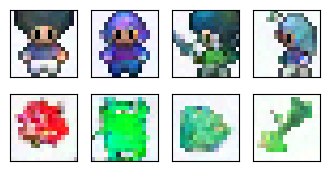

In [ ]:
# user defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0],
    [1,0,0,0,0],
    [0,0,0,0,1],
    [0,0,0,0,1],
    [0,1,0,0,0],
    [0,1,0,0,0],
    [0,0,1,0,0],
    [0,0,1,0,0],
]).float().to(device)
samples, _ = sample_ddpm_context(nn_model, ctx.shape[0], ctx, timesteps, a_t, b_t, ab_t)
show_images(samples)

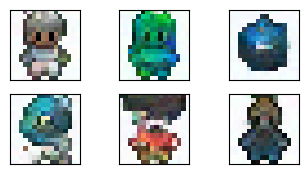

In [ ]:
# mix of defined context
ctx = torch.tensor([
    # hero, non-hero, food, spell, side-facing
    [1,0,0,0,0],      #human
    [1,0,0.6,0,0],
    [0,0,0.6,0.4,0],
    [1,0,0,0,1],
    [1,1,0,0,0],
    [1,0,0,1,0]
]).float().to(device)
samples, _ = sample_ddpm_context(nn_model, ctx.shape[0], ctx, timesteps, a_t, b_t, ab_t)
show_images(samples)

# Acknowledgments
Sprites by ElvGames, [FrootsnVeggies](https://zrghr.itch.io/froots-and-veggies-culinary-pixels) and  [kyrise](https://kyrise.itch.io/)   
Diffusion model is based on [Denoising Diffusion Probabilistic Models](https://arxiv.org/abs/2006.11239)